# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape

(891221, 85)

In [4]:
# Identify missing or unknown data values and convert them to NaNs.
def convert(x, missing):
    if x in missing:
        return np.nan
    else:
        return x

In [5]:
X = 'X'
XX = 'XX'
for col in azdias.columns:
    missing_values = eval(feat_info[feat_info['attribute']==col]['missing_or_unknown'].iloc[0])
    azdias[col] = azdias[col].apply(convert, missing = missing_values)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

(array([ 31.,   1.,   0.,   0.,   0.,   0.,   0.,   7.,   8.,  10.,   6.,
          7.,   6.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([      0.        ,   10459.54117647,   20919.08235294,
          31378.62352941,   41838.16470588,   52297.70588235,
          62757.24705882,   73216.78823529,   83676.32941176,
          94135.87058824,  104595.41176471,  115054.95294118,
         125514.49411765,  135974.03529412,  146433.57647059,
         156893.11764706,  167352.65882353,  177812.2       ,
         188271.74117647,  198731.28235294,  209190.

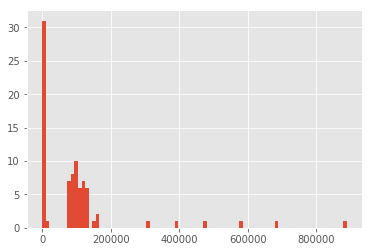

In [6]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
nan_df = azdias.isnull().sum().sort_values(ascending=False)
plt.hist(nan_df, bins = 85)

In [7]:
def get_upper_bound(data):
    q1, q3 = np.percentile(data,[25,75])
    iqr = q3 - q1
    u_b = q3 +(1.5 * iqr)
    return u_b

In [8]:
upper_bound = get_upper_bound(nan_df)
columns = nan_df[nan_df>upper_bound].index

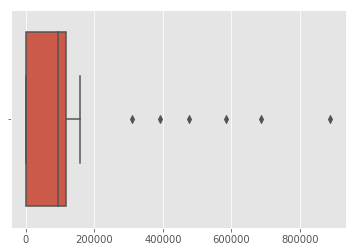

In [9]:
sns.boxplot(nan_df)

In [10]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias.drop(columns, inplace=True, axis=1)

#### Discussion 1.1.2: Assess Missing Data in Each Column

Due to missing or unknown values we deleted the following columns from the azdias dataset:
- TITEL_KZ
- AGER_TYP
- KK_KUNDENTYP
- KBA05_BAUMAX
- GEBURTSJAHR
- ALTER_HH

We can clearly see that these outlier columns are related to personal data. Except for "KBA05_BAUMAX" all columns are personal/household related data.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

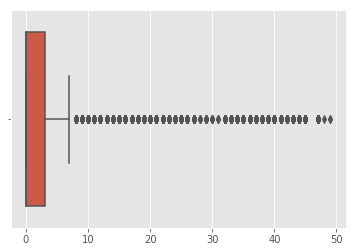

In [11]:
# How much data is missing in each row of the dataset?
nan_rows = azdias.isnull().sum(axis=1)
sns.boxplot(nan_rows)

In [12]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
upper_bound = get_upper_bound(nan_rows)
azdias['outlier_row'] = nan_rows > upper_bound

In [13]:
azdias_below = azdias[azdias['outlier_row']==False]
azdias_above = azdias[azdias['outlier_row']==True]

In [14]:
from scipy.stats import ks_2samp
comp_df = pd.DataFrame(azdias.columns, columns=['col'])
def hypothesis_test(df1, df2, cols):
    stats = []
    pvalues = []
    for col in cols:
        counts_main = df1[col].value_counts().sort_index()
        counts_drop = df2[col].value_counts().sort_index()
        try:
            ch = ks_2samp(counts_main, counts_drop)
            stats.append(ch.statistic)
            pvalues.append(ch.pvalue)
        except:
            stats.append(np.nan)
            pvalues.append(np.nan)

    return stats, pvalues

In [88]:
raucher = np.random.normal(50,6,2000)
nichtraucher = np.random.normal(60, 6, 2000)
ks_2samp(raucher, nichtraucher)

Ks_2sampResult(statistic=0.59950000000000003, pvalue=4.8673207037088696e-315)

In [59]:
ks_2samp(raucher, nichtraucher)

Ks_2sampResult(statistic=0.30000000000000004, pvalue=0.27526886726742111)

In [15]:
stats, pvalues = hypothesis_test(azdias_below, azdias_above, azdias_below.columns.values)
comp_df['stats'] = stats
comp_df['pvalues'] = pvalues
k = comp_df.sort_values(by = "pvalues")

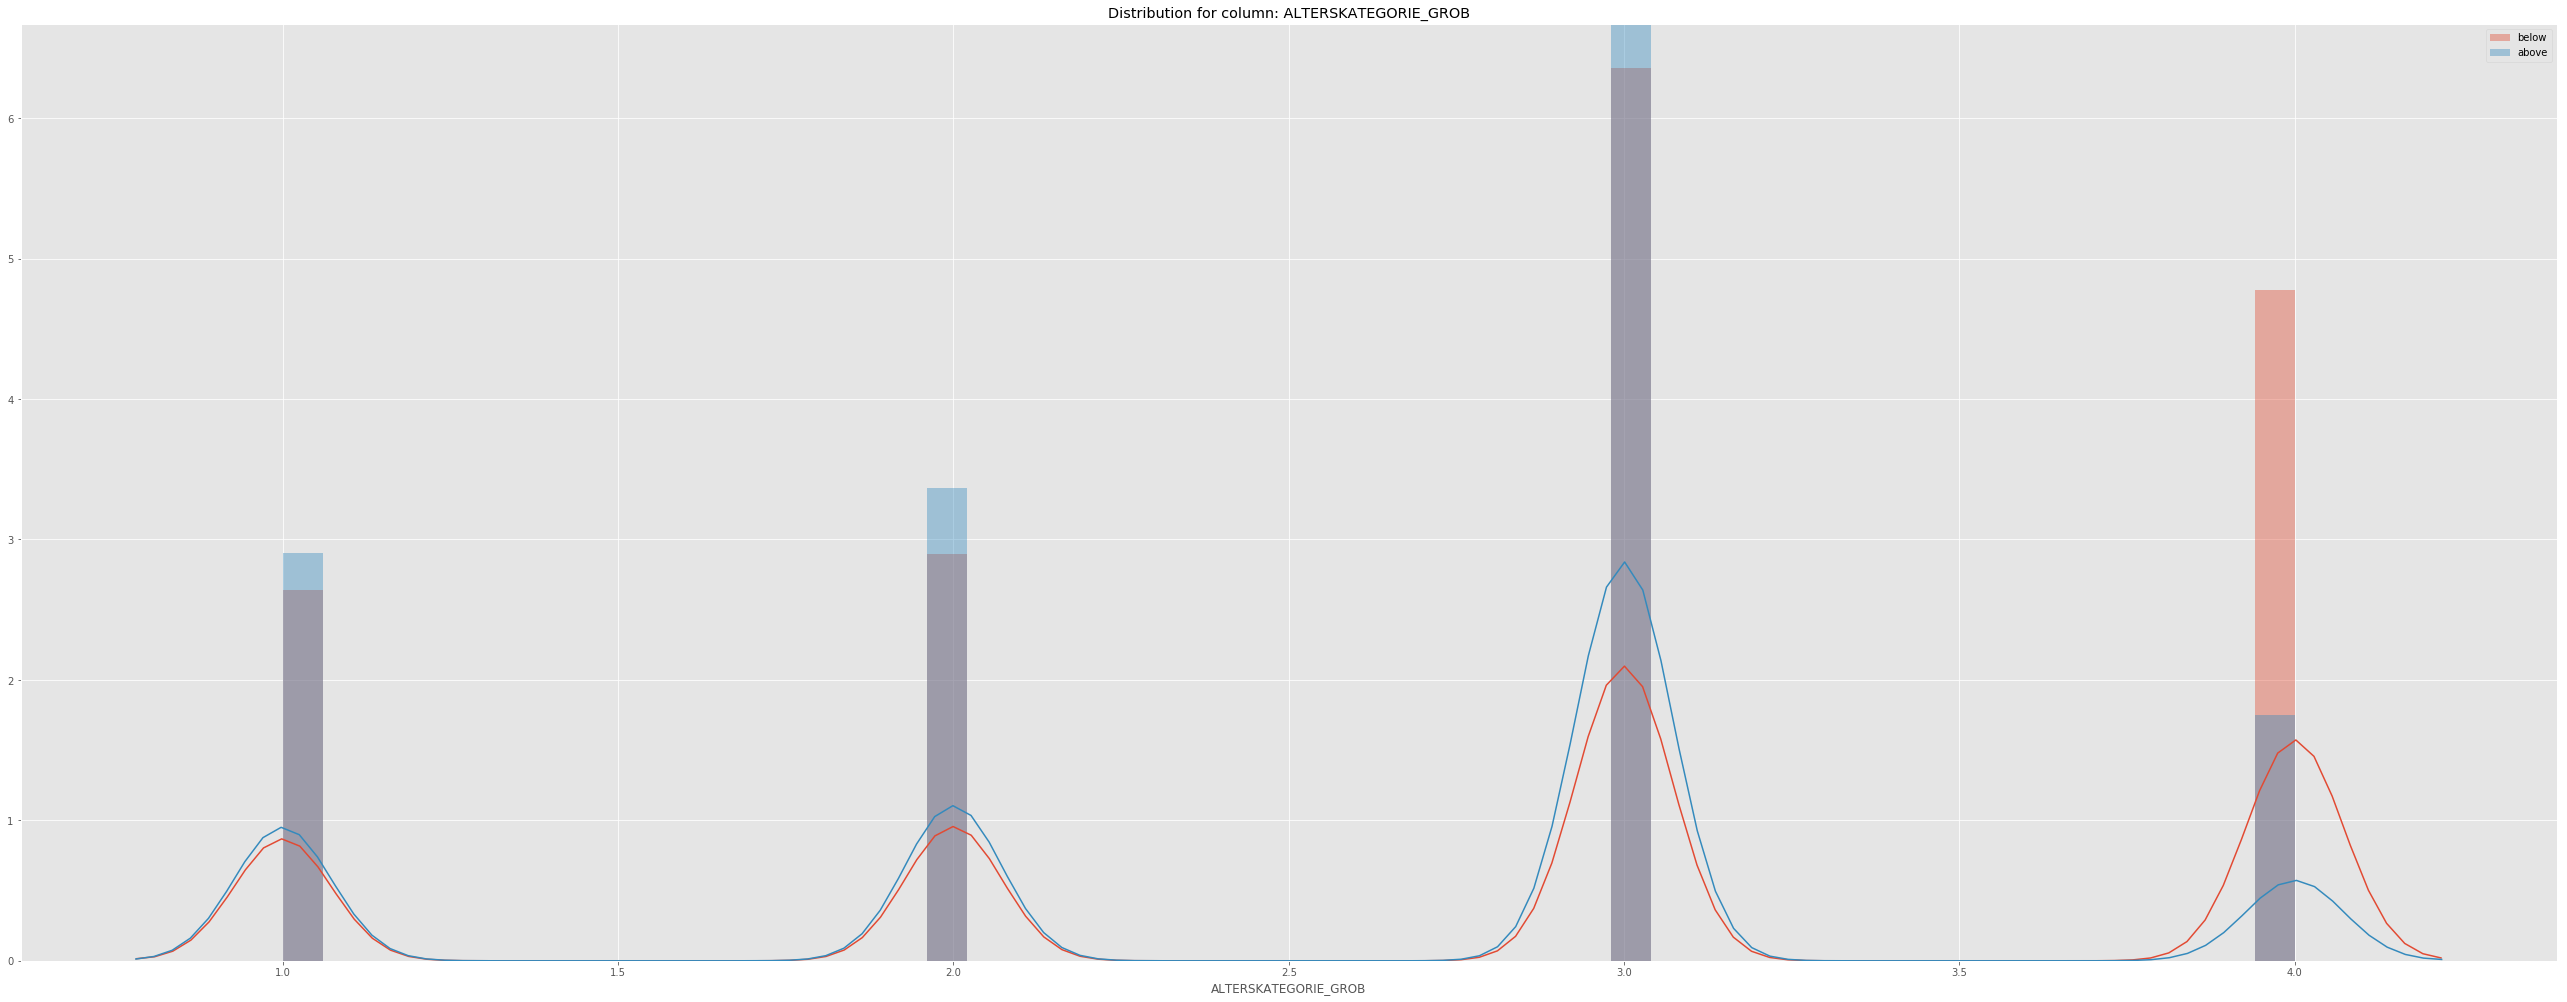

In [16]:
plt.figure(figsize=(100,100))
for i, col in enumerate(azdias.columns[:1]):
    plt.subplot(5, 2, i+1)
    sns.distplot(azdias_below[col][azdias_below[col].notnull()], label='below')
    sns.distplot(azdias_above[col][azdias_above[col].notnull()], label='above')
    plt.title('Distribution for column: {}'.format(col))
    plt.legend();

In [17]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
# for col in compare:
#     figure(num=None, figsize=(14, 4), dpi=80, facecolor='w', edgecolor='k')

#     plt.subplot(1, 2, 1)
#     plt.title('Many data available')
#     sns.countplot(azdias[azdias['outlier_row']==False][col])

#     plt.subplot(1, 2, 2)
#     plt.title('Missing data')
#     sns.countplot(azdias[azdias['outlier_row']==True][col])
#     plt.show()

In [18]:
azdias = azdias[azdias['outlier_row']==False]
azdias.drop('outlier_row', inplace=True, axis=1)

#### Discussion 1.1.3: Assess Missing Data in Each Row

In the cells above I created countplots for all 80 columns to compare the distributions of data values for data with many and few missing values.

For some columns, the data with lots of missing values are qualitatively different from data with few or no missing values. Example columns where the distribution of data values is different between the subsets are CJT_GESAMTTYP, FINANZ_MINIMALIST, FINANZ_SPARER, FINANZTYP or SEMIO_SOZ.   

However, there are also columns where the distribution is very similar. Examples are NATIONALITAET_KZ, GREEN_AVANTGARDE, ALTERSKATEGORIE_GROB, ANREDE_KZ or ANZ_TITEL.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [20]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
binaries = []
binary_non_numeric = []
multi_level = []

for col in azdias.columns:
    if feat_info[feat_info['attribute']==col]['type'].iloc[0] == 'categorical':
        values = azdias[col].unique()
        cleaned_values = [x for x in values if str(x) != 'nan']
        if len(cleaned_values) == 2:
            try: 
                for i in cleaned_values:
                    int(i)
                binaries.append(col)
            except ValueError:
                binary_non_numeric.append(col)
        else:
            multi_level.append(col)

In [21]:
# Re-encode categorical variable(s) to be kept in the analysis.
di = {'W': 0, 'O': 1}
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].map(di)
azdias.drop(multi_level, inplace=True, axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

I kept the binary (two-level) categoricals that take numeric values without any changes. Then I re-encoded the binary feature OST_WEST_KZ from non-numeric values to numbers. I dropped the remaining multi-level features to reduce the dimensionality and to avoid possible structural conflicts with the customers dataset. With structural conflicts I mean that there is the possibility that one-hot encoding may lead to future problems if the two datasets do not have the same number of columns after one-hot encoding. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [22]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
mainstream = [1, 3, 5, 8, 10, 12, 14]
avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]

def convert_decade(x):
    if np.isnan(x):
        return np.nan
    elif x < 3:
        return 0
    elif x < 5:
        return 1
    elif x < 8:
        return 2
    elif x < 10:
        return 3
    elif x < 14:
        return 4
    else:
        return 5

def convert_movement(x):
    if x in mainstream:
        return 0
    elif x in avantgarde:
        return 1

In [23]:
azdias['decade'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(convert_decade)
azdias['movement'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(convert_movement)

In [24]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def convert_wealth(x):
    if pd.isnull(x):
        return np.nan
    if x[0] == '1':
        return 0
    elif x[0] == '2':
        return 1
    elif x[0] == '3':
        return 2
    elif x[0] == '4':
        return 3
    else:
        return 4

def convert_lifestage(x):
    if pd.isnull(x):
        return np.nan
    if x[1] == '1':
        return 0
    elif x[1] == '2':
        return 1
    elif x[1] == '3':
        return 2
    elif x[1] == '4':
        return 3
    else:
        return 4

In [25]:
azdias['wealth'] = azdias['CAMEO_INTL_2015'].apply(convert_wealth)
azdias['life_stage'] = azdias['CAMEO_INTL_2015'].apply(convert_lifestage)

In [26]:
# drop mixed columns 
cols = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']
azdias.drop(cols, inplace=True, axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Based on the features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 I created four new features. 
I decided to drop the other mixed features as we already retrieved most of these information from the engineered mixed features. For example, the mixed features LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB provide information about the life stage of the person which is already covered by the engineered feature life_stage. Additionally, I assume that WOHNLAGE is strongly correlated with the prosperity of a person. Accordingly, I also dropped the feature PLZ8_BAUMAX (KBA05_BAUMAX was already removed from the dataset).


In [27]:
# check columns
k = azdias.columns
feat_info[feat_info['attribute'].isin(k)]

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]
13,GREEN_AVANTGARDE,person,categorical,[]
14,HEALTH_TYP,person,ordinal,"[-1,0]"


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [28]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for col in df.columns:
        missing_values = eval(feat_info[feat_info['attribute']==col]['missing_or_unknown'].iloc[0])
        df[col] = df[col].apply(convert, missing = missing_values)
    
    # remove selected columns
    df.drop(columns, inplace=True, axis=1)
    
    # remove selected rows
    nan_rows = df.isnull().sum(axis=1)
    upper_bound_rows = get_upper_bound(nan_rows)
    df['outlier_row'] = nan_rows > upper_bound_rows
    df = df[df['outlier_row']==False]
    df.drop('outlier_row', inplace=True, axis=1)
    
    # select, re-encode, and engineer column values.
    binaries = []
    binary_non_numeric = []
    multi_level = []

    for col in df.columns:
        if feat_info[feat_info['attribute']==col]['type'].iloc[0] == 'categorical':
            values = df[col].unique()
            cleaned_values = [x for x in values if str(x) != 'nan']
            if len(cleaned_values) == 2:
                try: 
                    for i in cleaned_values:
                        int(i)
                    binaries.append(col)
                except ValueError:
                    binary_non_numeric.append(col)
            else:
                multi_level.append(col)
                
    df.drop(multi_level, inplace=True, axis=1)

    di = {'W': 0, 'O': 1}
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map(di)
    
    df['decade'] = df['PRAEGENDE_JUGENDJAHRE'].apply(convert_decade)
    df['movement'] = df['PRAEGENDE_JUGENDJAHRE'].apply(convert_movement)
        
    df['wealth'] = df['CAMEO_INTL_2015'].apply(convert_wealth)
    df['life_stage'] = df['CAMEO_INTL_2015'].apply(convert_lifestage)
    df.drop(cols, inplace=True, axis=1)
    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [29]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer

fill_NaN = Imputer(missing_values=np.nan, strategy='mean', axis=0)

imputed_DF = pd.DataFrame(fill_NaN.fit_transform(azdias))
imputed_DF.columns = azdias.columns
imputed_DF.index = azdias.index

In [30]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(imputed_DF)

### Discussion 2.1: Apply Feature Scaling

Due to the fact that I do not want to delete any rows I decided to impute the dataframe with mean values along the features axes. If I just dropped data points with any missing values I would have reduced the dataset from 747.109 to 623.211. I think that imputing is a valid strategy as we already removed outlier columns with a lot of missing values. So we do not impute many data points from few data points but rather the other way around. 

Afterwards, I standardized each feature to mean 0 and standard deviation 1. The standardized values can be interpreted as the number of standard deviations they fluctuate around the mean.


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [31]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

pca = PCA(random_state=42)
X_pca = pca.fit_transform(scaled_data)

In [32]:
# Function to create scree plot.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

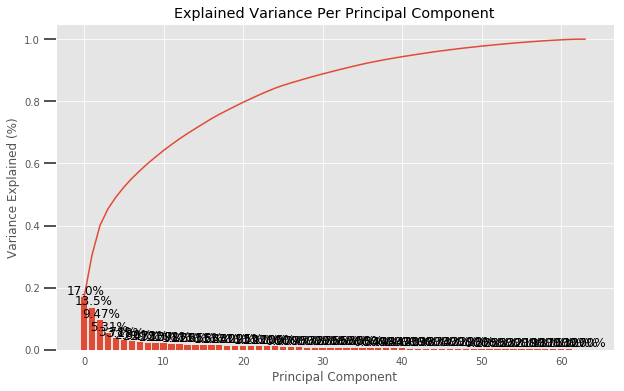

In [33]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [34]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=20, random_state=42)
X_pca = pca.fit_transform(scaled_data)

### Discussion 2.2: Perform Dimensionality Reduction

I decided to keep 20 principal components. I tried to retrieve a good indication of when we hit the point of diminishing returns. The scree plot depicts that little variance is gained by retaining additional eigenvalues above 20 principal components. I believe that 20 principal components are enough as they explain 80% of the variance in the data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [35]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def get_features(component, pca_object):
    feature_names = azdias.columns
    arr = pca_object.components_[component-1]
    arr_abs = np.abs(arr)
    top_5 = arr_abs.argsort()[-10:][::-1]
    k = 1
    print('For Principal Component ' + str(component) + ':')
    for i in top_5: 
        print('Feature ' + str(k) + ': '+  (feature_names[i]) + ', weight: ' + str(arr[i]))
        k+=1

get_features(1, pca)

For Principal Component 1:
Feature 1: MOBI_REGIO, weight: -0.241541409361
Feature 2: KBA05_ANTG1, weight: -0.225093074658
Feature 3: PLZ8_ANTG1, weight: -0.224956688762
Feature 4: PLZ8_ANTG3, weight: 0.224928556632
Feature 5: FINANZ_MINIMALIST, weight: -0.219377167162
Feature 6: PLZ8_ANTG4, weight: 0.2180743956
Feature 7: KBA05_GBZ, weight: -0.216593275111
Feature 8: wealth, weight: 0.205910541597
Feature 9: HH_EINKOMMEN_SCORE, weight: 0.202695402347
Feature 10: ORTSGR_KLS9, weight: 0.195096432026


In [36]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
get_features(2, pca)

For Principal Component 2:
Feature 1: ALTERSKATEGORIE_GROB, weight: 0.257110734054
Feature 2: SEMIO_REL, weight: -0.255349219264
Feature 3: decade, weight: -0.248048865534
Feature 4: FINANZ_SPARER, weight: -0.234057468363
Feature 5: FINANZ_VORSORGER, weight: 0.229863723018
Feature 6: SEMIO_TRADV, weight: -0.229227784113
Feature 7: SEMIO_ERL, weight: 0.228918712783
Feature 8: SEMIO_PFLICHT, weight: -0.227973984521
Feature 9: FINANZ_UNAUFFAELLIGER, weight: -0.225272134045
Feature 10: SEMIO_KULT, weight: -0.218836502769


In [37]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
get_features(3, pca)

For Principal Component 3:
Feature 1: ANREDE_KZ, weight: -0.369482448063
Feature 2: SEMIO_VERT, weight: 0.34791150522
Feature 3: SEMIO_KAEM, weight: -0.338107078681
Feature 4: SEMIO_DOM, weight: -0.313744244591
Feature 5: SEMIO_KRIT, weight: -0.271738844607
Feature 6: SEMIO_SOZ, weight: 0.264094582402
Feature 7: SEMIO_FAM, weight: 0.251313545272
Feature 8: SEMIO_KULT, weight: 0.233463087418
Feature 9: SEMIO_RAT, weight: -0.21722928619
Feature 10: FINANZ_ANLEGER, weight: -0.187625219764


### Discussion 2.3: Interpret Principal Components
#### 1st Principal Component
The first principal component looks at the features MOBI_REGIO, KBA05_ANTG1 and PLZ8_ANTG1 the most. The first three features have a negative sign, so they seem to be correlated with each other.

The features have the following meaning:
- MOBI_REGIO (high movement -> low movement)  
- KBA05_ANTG1 (low share of 1-2 family homes -> high share of 1-2 family homes)
- PLZ8_ANTG1 (low share of 1-2 family homes -> high share of 1-2 family homes)

If we also take into account the features wealth (wealthy->poor) and HH_EINKOMMEN_SCORE (high income -> low income), we can see that, the more wealthy the persons are, the less do they move and the higher is the share of 1-2 family homes in their region. All of these relations do make completely sense to me.


#### 2nd Principal Component
The 2nd principal component mainly looks at these features:
- ALTERSKATEGORIE_GROB (young people -> old people)
- SEMIO_REL (religous->not religious)
- decade (40s -> 90s)
- FINANZ_SPARER (high money saver -> low money saver)

From the weights of the features we can see that the engineered feature decade works just fine. There is a strong negative correlation between decade and ALTERSKATEGORIE_GROB which just means that people who had their youth in the 40s are older than people who had their youth after the 40s (like 50s, 60s,...). This makes sense. We can also see that older people are stronger money-saver that young people (correlation between ALTERSKATEGORIE_GROB and FINANZ_SPARER). Additionally, young people do not tend to be as religious as older people.



#### 3rd Principal Component
The 3rd principal component mainly looks at these features:
- ANREDE_KZ (male -> female)
- SEMIO_VERT (dreamful -> not dreamful)
- SEMIO_KAEM (combative -> not combative)

We can see that males are not as dreamful as females. Instead, males show combative behaviour more oftenly that females. From the additional features we can see that males are: 
- more dominant-minded,
- less critical-minded, 
- less family-minded,
- less socially-minded,
- less cultural-minded,
- more event-oriented,
- more rational. 

All of these observations are no causalities, but correlations. Correlation does not imply causation.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

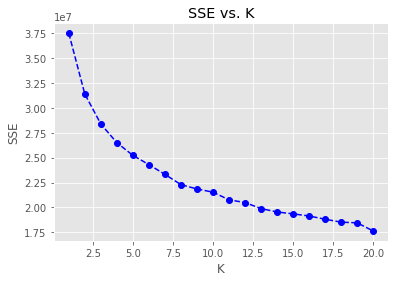

In [38]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    clustering = MiniBatchKMeans(n_clusters=center, random_state=0, batch_size=10000)

    # Then fit the model to your data using the fit method
    model = clustering.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score


scores = []
centers = list(range(1,21))

for center in centers:
    scores.append(get_kmeans_score(X_pca, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');
    

In [39]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
#instantiate kmeans
kmeans = KMeans(n_clusters=8, random_state=42)

# Then fit the model to your data using the fit method
model = kmeans.fit(X_pca)
labels = kmeans.labels_

### Discussion 3.1: Apply Clustering to General Population

I have decided to segment the population in 8 different clusters. This can be explained by looking at the plot which visualizes the elbow method. The distances between the points still decrease, but at a much lower rate.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [40]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")

In [41]:
customers_cleaned = clean_data(customers)

In [42]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# impute the customers dataset
imputed_customers = pd.DataFrame(fill_NaN.transform(customers_cleaned))
imputed_customers.columns = customers_cleaned.columns
imputed_customers.index = customers_cleaned.index

# standardize the customers dataset
scaled_customers = scaler.transform(imputed_customers)

# reduce dimensionality
customers_pca = pca.transform(scaled_customers)

# predict clusters 
customer_pred = model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

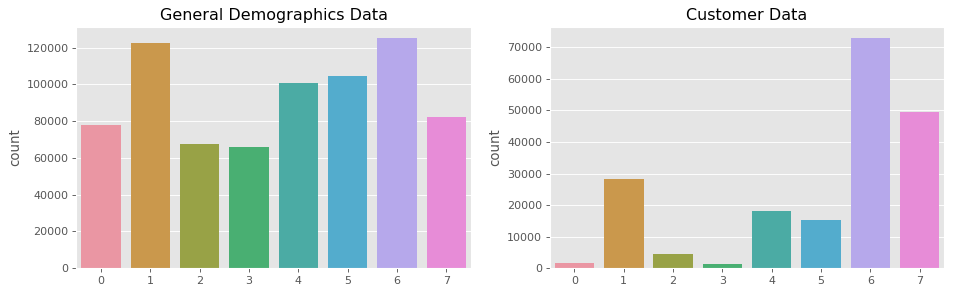

In [43]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure(num=None, figsize=(14, 4), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)
plt.title('General Demographics Data')
sns.countplot(labels)

plt.subplot(1, 2, 2)
plt.title('Customer Data')
sns.countplot(customer_pred)
plt.show()

In [44]:
# compute the cluster ratios
labels_ratios = (pd.Series(labels).value_counts()/pd.Series(labels).value_counts().sum()).sort_index()
customer_pred_ratios = (pd.Series(customer_pred).value_counts()/pd.Series(customer_pred).value_counts().sum()).sort_index()

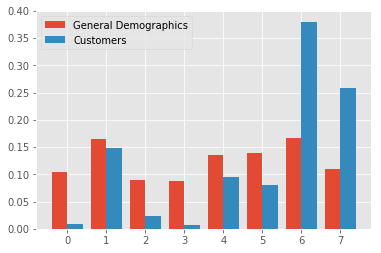

In [45]:
# plot the cluster ratios
X = labels_ratios.index
plt.bar(X-0.2, labels_ratios, width = 0.4, label='General Demographics')
plt.bar(X+0.2, customer_pred_ratios, width = 0.4, label='Customers')
plt.legend(loc='best')
plt.xticks(X)
plt.show()

In [46]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# change cluster variable to overrepresented or underrepresented cluster
cluster = 0
# change factor variable to get different amount of columns for comparison
factor = 1
compare_columns = []
for col in imputed_DF.columns:
    upper = imputed_DF[col].describe().loc["mean"] + factor*(imputed_DF[col].describe().loc["std"])
    lower = imputed_DF[col].describe().loc["mean"] - factor*(imputed_DF[col].describe().loc["std"])
    x = imputed_DF[labels==cluster][col].describe().loc["mean"]
    if x < lower or x > upper:
        compare_columns.append(col)
print(compare_columns)

['FINANZ_MINIMALIST', 'FINANZ_SPARER', 'SEMIO_VERT', 'SEMIO_RAT', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV']


In [47]:
imputed_DF[compare_columns].describe()

,FINANZ_MINIMALIST,FINANZ_SPARER,SEMIO_VERT,SEMIO_RAT,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV
count,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000
mean,3.060425,2.689336,4.271101,3.872597,4.289428,4.158634,3.732403
std,1.370273,1.481252,1.928741,1.662714,1.877453,1.882164,1.768607
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,3.000000,3.000000,3.000000,2.000000
50%,3.000000,3.000000,5.000000,4.000000,4.000000,4.000000,4.000000
75%,4.000000,4.000000,6.000000,5.000000,6.000000,6.000000,5.000000
max,5.000000,5.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [48]:
imputed_DF[labels==cluster][compare_columns].describe()

,FINANZ_MINIMALIST,FINANZ_SPARER,SEMIO_VERT,SEMIO_RAT,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV
count,78106.000000,78106.000000,78106.000000,78106.000000,78106.000000,78106.000000,78106.000000
mean,1.261427,4.303024,2.185530,6.299145,6.331229,6.088713,5.804740
std,0.567576,0.960243,0.910322,1.069911,0.765291,1.032053,1.614031
min,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000
25%,1.000000,4.000000,2.000000,6.000000,6.000000,6.000000,6.000000
50%,1.000000,5.000000,2.000000,7.000000,6.000000,6.000000,6.000000
75%,1.000000,5.000000,2.000000,7.000000,7.000000,7.000000,7.000000
max,5.000000,5.000000,5.000000,7.000000,7.000000,7.000000,7.000000


In [103]:
def plot_scaled_comparison(df_sample, kmeans, cluster):
    X = pd.DataFrame.from_dict(dict(zip(df_sample.columns,
                                        pca.inverse_transform(kmeans.cluster_centers_[cluster]))), orient='index').rename(
                                        columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)
    X['feature_values_abs'] = abs(X['feature_values'])
    pd.concat((X['feature_values'][:10], X['feature_values'][-10:]), axis=0).plot(kind='barh')
    return X

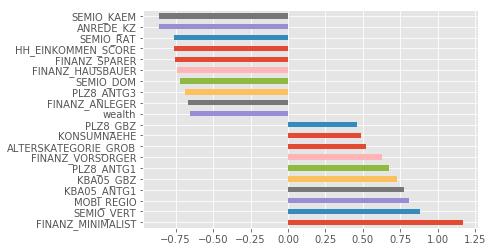

In [104]:
Y = plot_scaled_comparison(imputed_DF[labels==6], kmeans, 6)

### Discussion 3.3: Compare Customer Data to Demographics Data

The following kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population:
- Most of the people are male.
- The people have a high financial interest. 
- The people have a high income.
- The people own houses.
- The people are less dreamful.
- The people rather have a combative attitude.
- In the microcell there is a higher share of 1-2 family homes.
- The people do not move very often.

In contrast, the following kinds of people are part of a cluster that is underrepresented in the customer data:
- The people have a low financial interest.
- The people do not save much money. 
- The people are more dreamful, less rational, less combative, less dutiful and less traditional-minded. 

These information about the customers can be used to better target the marketing activities.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.